# Exploring building reference datasets with kerchunk

The idea: build a test intake catalogue of kerchunk virtual dataset(s) from the COSIMA output(s) and see how it performs

In [1]:
import os
import glob

import ujson

import fsspec

import zarr

import xarray as xr

from distributed import Client

from kerchunk import hdf, combine, df
import fsspec.implementations.reference

In [2]:
%cd /g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake

/g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake


In [3]:
client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

# Build a reference dataset for COSIMA `access-om2-025` `025deg_jra55_iaf_omip2_cycle1` `ocean_month` data (~2.2TB, 61 netcdf files)

In [4]:
exp_root = "/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1"

files = sorted(glob.glob(f"{exp_root}/output*/ocean/ocean_month.nc"))

## Prepare combined kerchunk virtual dataset in parallel
The version of `auto_dask` below includes a fix of [an existing bug](https://github.com/fsspec/kerchunk/issues/306). I'm still having issues with workers dying using this function. Might be easiest just to do manually for now.

In [ ]:
from typing import List

from kerchunk.combine import MultiZarrToZarr

def auto_dask(
    urls: List[str],
    single_driver: str,
    single_kwargs: dict,
    mzz_kwargs: dict,
    n_batches: int,
    remote_protocol=None,
    remote_options=None,
    filename=None,
    output_options=None,
):
    """Batched tree combine using dask.

    If you wish to run on a distributed cluster (recommended), create
    a client before calling this function.

    Parameters
    ----------
    urls: list[str]
        input dataset URLs
    single_driver: class
        class with ``translate()`` method
    single_kwargs: to pass to single-input driver
    mzz_kwargs: passed to ``MultiZarrToZarr`` for each batch
    n_batches: int
        Number of MZZ instances in the first combine stage. Maybe set equal
        to the number of dask workers, or a multple thereof.
    remote_protocol: str | None
    remote_options: dict
        To fsspec for opening the remote files
    filename: str | None
        Ouput filename, if writing
    output_options
        If ``filename`` is not None, open it with these options

    Returns
    -------
    reference set
    """
    import dask

    # make delayed functions
    single_task = dask.delayed(lambda x: single_driver(x, **single_kwargs).translate())
    post = mzz_kwargs.pop("postprocess", None)
    inline = mzz_kwargs.pop("inline_threshold", None)
    # TODO: if single files produce list of reference sets (e.g., grib2)
    batch_task = dask.delayed(
        lambda u, x: MultiZarrToZarr(
            u,
            indicts=x,
            remote_protocol=remote_protocol,
            remote_options=remote_options,
            **mzz_kwargs,
        ).translate()
    )

    # sort out kwargs
    dims = mzz_kwargs.get("concat_dims", [])
    dims += [k for k in mzz_kwargs.get("coo_map", []) if k not in dims]
    kwargs = {"concat_dims": dims}
    if post:
        kwargs["postprocess"] = post
    if inline:
        kwargs["inline_threshold"] = inline
    for field in ["remote_protocol", "remote_options", "coo_dtypes", "identical_dims"]:
        if field in mzz_kwargs:
            kwargs[field] = mzz_kwargs[field]
    final_task = dask.delayed(
        lambda x: MultiZarrToZarr(
            x, remote_options=remote_options, remote_protocol=remote_protocol, **kwargs
        ).translate(filename, output_options)
    )

    # make delayed calls
    tasks = [single_task(u) for u in urls]
    tasks_per_batch = -(-len(tasks) // n_batches)
    tasks2 = []
    for batch in range(n_batches):
        in_tasks = tasks[batch * tasks_per_batch : (batch + 1) * tasks_per_batch]
        u = urls[batch * tasks_per_batch : (batch + 1) * tasks_per_batch]
        if in_tasks:
            # skip if on last iteration and no remaining tasks
            tasks2.append(batch_task(u, in_tasks))
    return dask.compute(final_task(tasks2))[0]

In [ ]:
%%time

mzz = auto_dask(
    files,
    single_driver=hdf.SingleHdf5ToZarr,
    single_kwargs={},
    mzz_kwargs=dict(
        concat_dims=['time'],
        identical_dims=[
            "xt_ocean", 
            "yt_ocean", 
            "st_ocean", 
            "xu_ocean", 
            "yu_ocean", 
            "sw_ocean", 
            "grid_xt_ocean", 
            "grid_yt_ocean", 
            "grid_xu_ocean", 
            "grid_yu_ocean", 
            "potrho", 
            "neutral",
            "nv"
         ]
    ),
    n_batches=4,
)

## Write to a json file

In [ ]:
with open("./kerchunk_dataset.json", 'wb') as f:
    f.write(ujson.dumps(mzz).encode());

## Consolidate metadata

In [ ]:
m = fsspec.get_mapper(
    'reference://', 
    fo="kerchunk_dataset.json", 
    remote_protocol="file"
)
zarr.convenience.consolidate_metadata(m)
m.fs.save_json("./kerchunk_dataset_consolidated.json")

## Write to parquet

In [ ]:
os.mkdir("./kerchunk_dataset.parq")
df.refs_to_dataframe(mzz, "./kerchunk_dataset.parq", partition=True)

# Compute on the reference datasets and compare to `open_mfdataset`

## 1. Reference JSON dataset

In [4]:
%%time

m = fsspec.get_mapper(
    'reference://', 
    fo="./kerchunk_dataset_consolidated.json", 
    remote_protocol="file"
)

ds = xr.open_dataset(
    m,
    engine='zarr', 
    backend_kwargs={"consolidated": True},
    chunks="auto",
    decode_times=False
)

CPU times: user 18.6 s, sys: 3.49 s, total: 22.1 s
Wall time: 21.3 s


In [5]:
%%time

# This compute comprises 71 dask tasks and uses 3-4GB of (unmanaged) memory per worker
global_mean = ds["sst"].mean(["xt_ocean", "yt_ocean"]).compute()

CPU times: user 17 s, sys: 4.69 s, total: 21.7 s
Wall time: 1min 8s


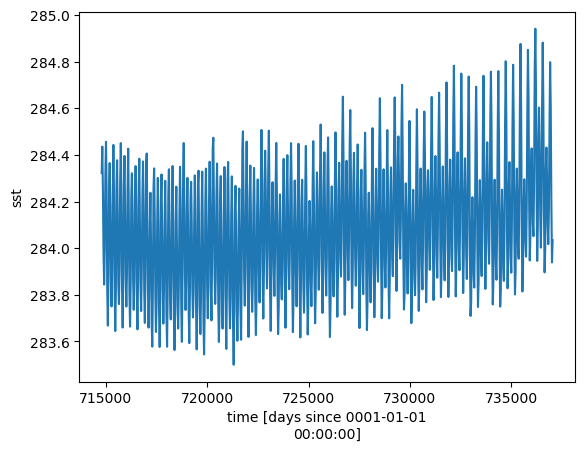

In [6]:
global_mean.plot()

## 2. Reference parquet dataset

In [4]:
%%time

m = fsspec.implementations.reference.DFReferenceFileSystem(
    "kerchunk_dataset.parq", lazy=True
).get_mapper()

ds = xr.open_dataset(
    m,
    engine="zarr",
    backend_kwargs={"consolidated": False},
    decode_times=False,
    chunks="auto"
)

CPU times: user 2.29 s, sys: 394 ms, total: 2.68 s
Wall time: 2.77 s


In [5]:
%%time

# This compute comprises 71 dask tasks and uses 300-500 MB of (unmanaged) memory per worker
global_mean = ds["sst"].mean(["xt_ocean", "yt_ocean"]).compute()

CPU times: user 2.74 s, sys: 936 ms, total: 3.67 s
Wall time: 10.5 s


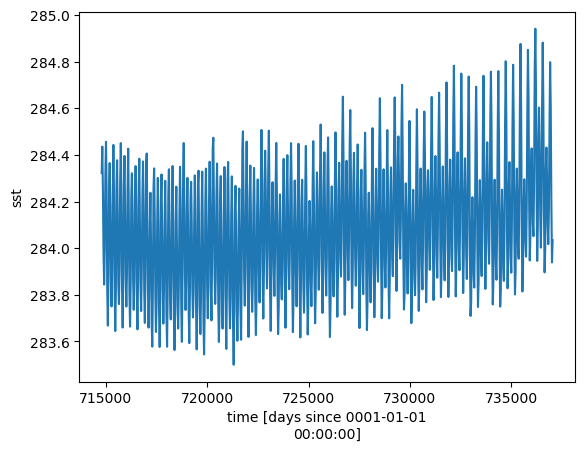

In [6]:
global_mean.plot()

## 3. `open_mfdataset`

In [5]:
%%time

ds = xr.open_mfdataset(
    files,
    chunks="auto",
    concat_dim="time",
    parallel=True,
    combine="nested",
    data_vars="minimal", 
    coords="minimal", 
    compat="override"
)

CPU times: user 5.55 s, sys: 619 ms, total: 6.17 s
Wall time: 7.2 s


In [6]:
%%time

# This compute comprises 305 dask tasks and uses ~100MB of unmanaged memory
global_mean = ds["sst"].mean(["xt_ocean", "yt_ocean"]).compute()

CPU times: user 985 ms, sys: 209 ms, total: 1.19 s
Wall time: 2.47 s


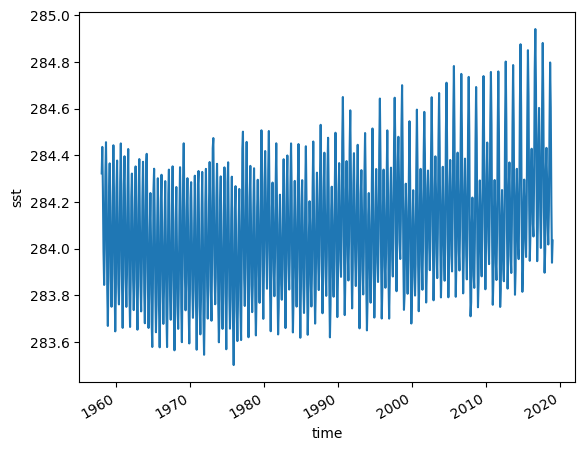

In [7]:
global_mean.plot()

## Notes (some outdated)

- The main impediment to this sort of approach at the moment is that kerchunk references are stored as inefficient json files which can be very large for datasets comprising many chunks. Currently this entire file is loaded with `open_dataset` (and loaded onto each worker when using a distributed cluster) which can require lots of memory and overhead. This outweighs the benefits kerchunk provides in this application (consolidation + zarr simplicity/performance).

- This said, there are a number of things in the kerchunk pipeline that should address the above issue: 1) new data structures for the reference set(s) that facilitate lazy loading (see https://github.com/fsspec/kerchunk/issues/240 and https://github.com/fsspec/kerchunk/issues/134), 2) the ability the split/combine chunks within a reference file but this would have limitations (e.g. couldn't work for particular types of compression, see https://github.com/fsspec/kerchunk/issues/124 and https://github.com/fsspec/kerchunk/issues/134).

- The approach of generating reference datasets for new experiments should be relatively straight-forward if we can have some confidence that all input files will be readily "concatenatable" in the sense that they have the same chunking patterns, coordinates on fixed dims, fixed auxiliary coordinates, variables (where approapriate) etc. The latest functionality for combining references in kerchunk is pretty versatile, see https://fsspec.github.io/kerchunk/tutorial.html#using-coo-map.

- Where the raw data are unchunked (e.g. netcdf3), this approach can significantly impact performance since fsspec will make the full range request even for subsets (https://github.com/fsspec/kerchunk/issues/124).

In [ ]:
client.close()